### EM solver on one patch of the cubed sphere

In [14]:
import numpy as N
import matplotlib.pyplot as P
from math import *

import sys
from figure_module import *

In [15]:
# Parameters
r = 1.0
cfl = 0.1

Nxi = 128
Neta = 128
NG = 2 # Number of ghosts zones
xi_min, xi_max = - N.pi / 4.0, N.pi / 4.0
eta_min, eta_max = - N.pi / 4.0, N.pi / 4.0
dxi = (xi_max - xi_min) / Nxi
deta = (eta_max - eta_min) / Neta

xi  = N.linspace(xi_min - NG * dxi, xi_max + NG * dxi, Nxi + 2 * NG)
eta = N.linspace(eta_min - NG * deta, eta_max + NG * deta, Neta + 2 * NG)

xi_grid, eta_grid = N.meshgrid(eta, xi)

xi_yee  = xi  + 0.5 * dxi
eta_yee = eta + 0.5 * deta

# Initialize fields
Eru = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Bru = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

E1d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

Eru0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1u0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2u0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
Bru0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B1u0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2u0 = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

In [16]:
# Metric tensor
g11d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g12d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g22d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):
        
        # 0 at (i, j)
        X = N.tan(xi[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 0] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 0] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 0] = - r * r * X * Y * C * C * D * D / (delta)**4
        
        # 1 at (i + 1/2, j)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 1] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 1] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 1] = - r * r * X * Y * C * C * D * D / (delta)**4
        
        # 2 at (i, j + 1/2)
        X = N.tan(xi[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 2] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 2] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 2] = - r * r * X * Y * C * C * D * D / (delta)**4

        # 3 at (i + 1/2, j + 1/2)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)

        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 3] = (r * C * C * D / (delta * delta))**2
        g22d[i, j, 3] = (r * C * D * D / (delta * delta))**2
        g12d[i, j, 3] = - r * r * X * Y * C * C * D * D / (delta)**4

sqrt_det_g = N.sqrt(g11d * g22d - g12d * g12d)
g11u = g11d / (sqrt_det_g * sqrt_det_g)
g22u = g22d / (sqrt_det_g * sqrt_det_g)
g12u = - g12d / (sqrt_det_g * sqrt_det_g)

dt = cfl * N.min(1.0 / N.sqrt(g11u / (dxi * dxi) + g22u / (deta * deta) + 2.0 * g12u / (dxi * deta)))
print("delta t = {}".format(dt))

delta t = 0.0005669125508928004


In [17]:
from itertools import chain

def contra_to_cov_E():
    
    for i in range(NG - 1, Nxi + NG + 1):
        for j in range(NG - 1, Neta + NG + 1):
            
            w1 = sqrt_det_g[i, j, 2]
            w2 = sqrt_det_g[i + 1, j - 1, 2]
            E1d[i, j] = g11d[i, j, 1] * E1u[i, j] + (w1 * g12d[i, j, 2] * E2u[i, j] + w2 * g12d[i + 1, j -1, 2] * E2u[i + 1, j - 1]) / (w1 + w2)
            
            # E1d[i, j] = g11d[i, j, 1] * E1u[i, j] + 0.5 * g12d[i, j, 1] * (E2u[i, j] + E2u[i + 1, j - 1])
            
            # E1d[i, j] = g11d[i, j, 1] * E1u[i, j] + 0.5 * (g12d[i, j, 2] * E2u[i, j] + g12d[i + 1, j - 1, 2] * E2u[i + 1, j - 1])

            w1 = sqrt_det_g[i, j, 1]
            w2 = sqrt_det_g[i - 1, j + 1, 1]
            E2d[i, j] = g22d[i, j, 2] * E2u[i, j] + (w1 * g12d[i, j, 1] * E1u[i, j] + w2 * g12d[i - 1, j + 1, 1] * E1u[i - 1, j + 1]) / (w1 + w2)
            
            # E2d[i, j] = g22d[i, j, 2] * E2u[i, j] + 0.5 * g12d[i, j, 2] * (E1u[i, j] + E1u[i - 1, j + 1])
            
            # E2d[i, j] = g22d[i, j, 2] * E2u[i, j] + 0.5 * (g12d[i, j, 1] * E1u[i, j] + g12d[i - 1, j + 1, 1] * E1u[i - 1, j + 1])

def contra_to_cov_B():
    
    for i in range(NG, Nxi + NG):
        for j in range(NG, Neta + NG):

            w1 = sqrt_det_g[i, j, 1]
            w2 = sqrt_det_g[i - 1, j + 1, 1]
            B1d[i, j] = g11d[i, j, 2] * B1u[i, j] + (w1 * g12d[i, j, 1] * B2u[i, j] + w2 * g12d[i - 1, j + 1, 1] * B2u[i - 1, j + 1]) / (w1 + w2)
            
            # B1d[i, j] = g11d[i, j, 2] * B1u[i, j] + 0.5 * g12d[i, j, 2] * (B2u[i, j] + B2u[i - 1, j + 1])
            
            # B1d[i, j] = g11d[i, j, 2] * B1u[i, j] + 0.5 * (g12d[i, j, 1] * B2u[i, j] + g12d[i - 1, j + 1, 1] * B2u[i - 1, j + 1])

            w1 = sqrt_det_g[i, j, 2]
            w2 = sqrt_det_g[i + 1, j - 1, 2]
            B2d[i, j] = g22d[i, j, 1] * B2u[i, j] + (w1 * g12d[i, j, 1] * B1u[i, j] + w2 * g12d[i + 1, j - 1, 2] * B1u[i + 1, j - 1]) / (w1 + w2)
            
            # B2d[i, j] = g22d[i, j, 1] * B2u[i, j] + 0.5 * g12d[i, j, 1] * (B1u[i, j] + B1u[i + 1, j - 1])
            
            # B2d[i, j] = g22d[i, j, 1] * B2u[i, j] + 0.5 * (g12d[i, j, 2] * B1u[i, j] + g12d[i + 1, j - 1, 2] * B1u[i + 1, j - 1])

def push_B():
    
    for i in range(NG, Nxi + NG):
        for j in range(NG, Neta + NG):
            Bru[i, j] -= ((E2d[i + 1, j] - E2d[i, j]) / dxi - (E1d[i, j + 1] - E1d[i, j]) / deta) * dt / sqrt_det_g[i, j, 3]

    for j in range(NG, Neta + NG):
        B1u[:, j] -= ((Eru[:, j + 1] - Eru[:, j]) / deta) * dt / sqrt_det_g[:, j, 2]
 
    for i in range(NG, Nxi + NG):
        B2u[i, :] += ((Eru[i + 1, :] - Eru[i, :]) / dxi) * dt / sqrt_det_g[i, :, 1]

def push_E(it):
    
    for i in range(NG, Nxi + NG):
        for j in range(NG, Neta + NG):
            Eru[i, j] += ((B2d[i, j] - B2d[i - 1, j]) / dxi - (B1d[i, j] - B1d[i, j - 1]) / deta) * dt / sqrt_det_g[i, j, 0] - 4.0 * N.pi * dt * Jr(it, i, j) 
 
    for j in range(NG, Neta + NG):
        E1u[:, j] += ((Bru[:, j] - Bru[:, j - 1]) / deta) * dt / sqrt_det_g[:, j, 1]

    for i in range(NG, Nxi + NG):
        E2u[i, :] -= ((Bru[i, :] - Bru[i - 1, :]) / dxi) * dt / sqrt_det_g[i, :, 2]

In [18]:
def BC_B_metal():
    
    for i in range(0, NG + 1):   
        B1u[i, :] = 0.0
    for i in range(0, NG):
        Bru[i, :] = 0.0
        B2u[i, :] = 0.0
    
    for i in range(Nxi + NG, Nxi + 2 * NG):
        B1u[i, :] = 0.0
        Bru[i, :] = 0.0
        B2u[i, :] = 0.0
        
    for j in range(0, NG + 1):
        B2u[:, j] = 0.0
    for j in range(0, NG):
        Bru[:, j] = 0.0
        B1u[:, j] = 0.0
        
    for j in range(Neta + NG, Neta + 2 * NG):
        B2u[:, j] = 0.0
        Bru[:, j] = 0.0
        B1u[:, j] = 0.0
           
def BC_E_metal():
    
    for i in range(0, NG + 1):        
        Eru[i, :] = 0.0
        E2u[i, :] = 0.0
    for i in range(0, NG):        
        E1u[i, :] = 0.0
        
    for i in range(Nxi + NG, Nxi + 2 * NG):
        Eru[i, :] = 0.0
        E2u[i, :] = 0.0
        E1u[i, :] = 0.0

    for j in range(0, NG + 1):
        Eru[:, j] = 0.0
        E1u[:, j] = 0.0
    for j in range(0, NG):        
        E2u[:, j] = 0.0

    for j in range(Neta + NG, Neta + 2 * NG):
        Eru[:, j] = 0.0
        E1u[:, j] = 0.0
        E2u[:, j] = 0.0

i_abs = 10

xi_abs = xi[i_abs]
delta_r = ((xi_abs - xi_grid) / (xi_abs - xi_min)) * N.heaviside(xi_abs - xi_grid, 0.0)
xi_abs = xi[Nxi + NG - i_abs]
delta_l = ((xi_grid - xi_abs) / (xi_max - xi_abs)) * N.heaviside(xi_grid - xi_abs, 0.0)

eta_abs = eta[i_abs]
delta_b = ((eta_abs - eta_grid) / (eta_abs - eta_min)) * N.heaviside(eta_abs - eta_grid, 0.0)
eta_abs = eta[Neta + NG - i_abs]
delta_u = ((eta_grid - eta_abs) / (eta_max - eta_abs)) * N.heaviside(eta_grid - eta_abs, 0.0)

# sigma = ((delta_l**3)  + (delta_r**3) + (delta_u**3) + (delta_b**3))
sigma = N.exp(- ((delta_l**3)  + (delta_r**3) + (delta_u**3) + (delta_b**3)))

def BC_B_absorb():
    B1u[:, :] *= sigma[:, :]
    B2u[:, :] *= sigma[:, :]
    Bru[:, :] *= sigma[:, :]
           
def BC_E_absorb():
    E1u[:, :] *= sigma[:, :]
    E2u[:, :] *= sigma[:, :]
    Eru[:, :] *= sigma[:, :]

def BC_B_periodic():
    
    for i in range(0, NG):   
        Bru[i, :] = Bru[i + Nxi, :]    
        B1u[i, :] = B1u[i + Nxi, :]  
        B2u[i, :] = B2u[i + Nxi, :]   
    
    for i in range(Nxi + NG, Nxi + 2 * NG):
        Bru[i, :] = Bru[i - Nxi, :]    
        B1u[i, :] = B1u[i - Nxi, :]  
        B2u[i, :] = B2u[i - Nxi, :]   

    for j in range(0, NG):
        Bru[:, j] = Bru[:, j + Neta]
        B1u[:, j] = B1u[:, j + Neta]
        B2u[:, j] = B2u[:, j + Neta]

    for j in range(Neta + NG, Neta + 2 * NG):
        Bru[:, j] = Bru[:, j - Neta]
        B1u[:, j] = B1u[:, j - Neta]
        B2u[:, j] = B2u[:, j - Neta]

def BC_E_periodic():
    
    for i in range(0, NG):   
        Eru[i, :] = Eru[i + Nxi, :]    
        E1u[i, :] = E1u[i + Nxi, :]  
        E2u[i, :] = E2u[i + Nxi, :]   
    
    for i in range(Nxi + NG, Nxi + 2 * NG):
        Eru[i, :] = Eru[i - Nxi, :]    
        E1u[i, :] = E1u[i - Nxi, :]  
        E2u[i, :] = E2u[i - Nxi, :]   

    for j in range(0, NG):
        Eru[:, j] = Eru[:, j + Neta]
        E1u[:, j] = E1u[:, j + Neta]
        E2u[:, j] = E2u[:, j + Neta]

    for j in range(Neta + NG, Neta + 2 * NG):
        Eru[:, j] = Eru[:, j - Neta]
        E1u[:, j] = E1u[:, j - Neta]
        E2u[:, j] = E2u[:, j - Neta]

In [19]:
# Initial conditions

theta0, phi0 = 90.0 / 360.0 * 2.0 * N.pi, 90.0 / 360.0 * 2.0 * N.pi # Center of the wave packet
w = 0.1 # Radius of wave packet
amp = 0.2 # Maximal amplitude
wave = 1.0
J0 = 2.0
B0 = 0.0

def shape_packet(x, y, z, width):
    # return amp * N.exp(- y * y / (width * width)) * N.exp(- x * x / (width * width)) * N.exp(- z * z / (width * width)) 
    return amp * N.exp(- x * x / (width * width)) * N.exp(- y * y / (width * width))

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):
        
        X = N.tan(xi[i])
        Y = N.tan(eta[j])

        theta = 0.5 * N.pi - N.arctan(Y / N.sqrt(1.0 + X * X))
        phi = N.arctan2(1.0 / N.sqrt(1.0 + X * X), X / N.sqrt(1.0 + X * X))

        x = N.sin(theta) * N.cos(phi)
        y = N.sin(theta) * N.sin(phi)
        z = N.cos(theta)
        
        x0 = N.sin(theta0) * N.cos(phi0)
        y0 = N.sin(theta0) * N.sin(phi0)
        z0 = N.cos(theta0)
        
        Eru0[i,j] = 0.0 #shape_packet(xi[i], eta[j], 0.0, w) # shape_packet(x - x0, y - y0, z - z0, w) # * N.cos(2.0 * N.pi * eta[j] / wave)
        B2u0[i,j] = 0.0 #- shape_packet(xi[i], eta[j], 0.0, w) # shape_packet(x - x0, y - y0, z - z0, w) # * N.sin(2.0 * N.pi * eta[j] / wave)
        B1u0[i,j] = 0.0
        Bru0[i,j] = 0.0 
        E1u0[i,j] = 0.0
        E2u0[i,j] = 0.0
        
        # print(theta,phi)

def Jr(it, i, j):
    return J0 * N.sin(20.0 * dt * it) * shape_packet(xi[i], eta[j], 0.0, w)


/tmp/ipykernel_258987/3295549235.py:11: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  f = P.pcolormesh(eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], E2u0[NG:(Nxi + NG), NG:(Neta + NG)] - B0, cmap = "RdBu_r", vmax = amp, vmin = - amp)
/tmp/ipykernel_258987/3295549235.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=fig.colorbar(f,cax=cax)


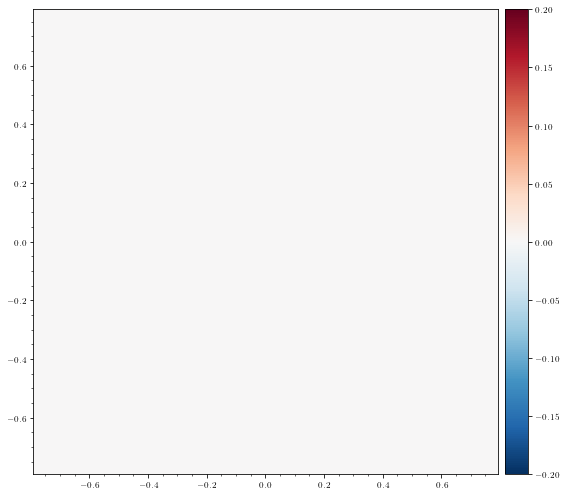

0.0

In [20]:
# Plot initial fields
%matplotlib inline

defrcparams(True)
fig_size=deffigsize(2.0,0.7)
ratio = 1.0

fig = P.figure(1, figsize = fig_size, facecolor = 'w')
ax = P.subplot(111)

f = P.pcolormesh(eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], E2u0[NG:(Nxi + NG), NG:(Neta + NG)] - B0, cmap = "RdBu_r", vmax = amp, vmin = - amp)
ax.set_aspect(1.0/ax.get_data_ratio()*ratio)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
cbar=fig.colorbar(f,cax=cax)
cbar.ax.tick_params(labelsize=9)
cbar.ax.minorticks_off()

P.show()

N.max(B2u0)

In [21]:
def plot_fields_plane(it, field):
    
    fig_size=deffigsize(2.0,0.7)
    ratio = 1.0

    fig = P.figure(1, figsize = fig_size, facecolor = 'w')
    ax  = P.subplot(111)
    if (field=="Bru"):
        vm=B0 + amp
    else:
        vm = amp

    f = P.pcolormesh(eta_grid, xi_grid, (globals()[field]), cmap = "RdBu_r", vmin = vm - 2.0 * amp, vmax = vm)
    # f = P.pcolormesh(eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], (globals()[field])[NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = vm - 2.0 * amp, vmax = vm)
    ax.set_aspect(1.0/ax.get_data_ratio()*ratio)
    P.xlabel(r"$\xi$")
    P.xlabel(r"$\eta$")

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar=fig.colorbar(f,cax=cax)
    cbar.ax.tick_params(labelsize=9)
    cbar.ax.minorticks_off()

    figsave_png("snapshots/" + field + "_" + str(it))
    
    P.close("all")

In [22]:
# Initialize simulation

Bru = Bru0
B1u = B1u0
B2u = B2u0
Eru = Eru0
E1u = E1u0
E2u = E2u0

BC_B_metal()
BC_E_metal()

iter = 0
idump = 0

B1d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
B2d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E1d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))
E2d = N.zeros((Nxi + 2 * NG, Neta + 2 * NG))

In [24]:
### Run the simulation
Nt = 1500 # Number of iterations
FDUMP = 10

for it in range(Nt):
    if ((it % FDUMP) == 0):
        plot_fields_plane(idump,"Eru")
        plot_fields_plane(idump,"B1u")
        plot_fields_plane(idump,"B2u")
        idump += 1

    print(it)
    iter += 1
    
    contra_to_cov_B()
    contra_to_cov_E()
        
    push_B()
    BC_B_metal()

    BC_B_absorb()

    push_E(it)
    BC_E_metal()
    BC_E_absorb()
    
    # push_B()
    # BC_B_periodic()
    # push_E(iter)
    # BC_E_periodic()

/tmp/ipykernel_258987/3573186761.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  f = P.pcolormesh(eta_grid, xi_grid, (globals()[field]), cmap = "RdBu_r", vmin = vm - 2.0 * amp, vmax = vm)
/tmp/ipykernel_258987/3573186761.py:21: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar=fig.colorbar(f,cax=cax)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27